In [59]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn.plotting import plot_img, plot_stat_map, view_img, plot_prob_atlas
from nilearn.regions import connected_label_regions
from nilearn.glm.first_level.hemodynamic_models import spm_hrf
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix, plot_roi
from nilearn.glm.second_level import SecondLevelModel
from nilearn.maskers import NiftiMapsMasker, NiftiSpheresMasker, NiftiMasker
from nilearn import image
from nilearn.image import binarize_img
from nilearn.image import high_variance_confounds
import seaborn as sns
from nilearn.masking import compute_multi_epi_mask

# Homemade functions

In [60]:
# Open a datasets directory. 
ses02_path = os.open("/Users/luisalvarez/Documents/Datasets/IBC/sub-15/ses-02/func", os.O_RDONLY)
ses26_path = os.open("/Users/luisalvarez/Documents/Datasets/IBC/sub-15/ses-26/func", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(ses02_path)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Datasets/IBC/sub-15/ses-02/func


## Load and check Cartmell et al. (2019) NAc Probabilistic Atlas.


In [61]:
# Define path for each segment of the atlas. 
LH_core = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/lh-presumed-core.nii.gz"
RH_core = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/rh-presumed-core.nii.gz"
LH_shell = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/lh-presumed-shell.nii.gz"
RH_shell = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/rh-presumed-shell.nii.gz"

NAcc_files = [LH_core, RH_core, LH_shell, RH_shell]
NAcc_core_files = [LH_core, RH_core]
NAcc_shell_files = [LH_shell, RH_shell]

## Create normal masks for NAcc, core, and shell. 
# Merge files into single atlas. 
# Complete mask, both NAcc core and shell.
NAcc_imgs = image.load_img(NAcc_files, wildcards=True)
NAcc_atlas = image.math_img('np.sum(img, axis=-1, keepdims=True)', img=NAcc_imgs)
NAcc_atlas_masker = NiftiMapsMasker(
        maps_img=NAcc_atlas,
        allow_overlap=True)

# Core mask: only NAcc core.
NAcc_imgs_core = image.load_img(NAcc_core_files, wildcards=True)
NAcc_atlas_core = image.math_img('np.sum(img, axis=-1, keepdims=True)', img=NAcc_imgs_core)
NAcc_atlas_masker_core = NiftiMapsMasker(
        maps_img=NAcc_atlas_core,
        allow_overlap=True)

# Shell mask: only NAcc shell.
NAcc_imgs_shell = image.load_img(NAcc_shell_files, wildcards=True)
NAcc_atlas_shell = image.math_img('np.sum(img, axis=-1, keepdims=True)', img=NAcc_imgs_shell)
NAcc_atlas_masker_shell = NiftiMapsMasker(
        maps_img=NAcc_atlas_shell,
        allow_overlap=True)



In [62]:
# Create filtered masks for NAcc, core, and shell.
# For these masks, only voxels with higher than 35% probability of being part of NAcc will be considered.

NAcc_filt_matrix = NAcc_atlas.get_fdata().copy()
NAcc_filt_matrix[NAcc_filt_matrix < 0.35] = 0
NAcc_atlas_filtered = nib.Nifti1Image(NAcc_filt_matrix, NAcc_atlas.affine, NAcc_atlas.header)
NAcc_atlas_masker_filt = NiftiMapsMasker(
        maps_img=NAcc_atlas_filtered,
        allow_overlap=True)

NAcc_imgs_core_matrix = NAcc_imgs_core.get_fdata().copy()
NAcc_imgs_core_matrix[NAcc_imgs_core_matrix < 0.35] = 0
NAcc_imgs_core_filtered = nib.Nifti1Image(NAcc_imgs_core_matrix, NAcc_imgs_core.affine, NAcc_imgs_core.header)
NAcc_atlas_masker_core_filt = NiftiMapsMasker(
        maps_img=NAcc_imgs_core_filtered,
        allow_overlap=True)

NAcc_imgs_shell_matrix = NAcc_imgs_shell.get_fdata().copy()
NAcc_imgs_shell_matrix[NAcc_imgs_shell_matrix < 0.35] = 0
NAcc_imgs_shell_filtered = nib.Nifti1Image(NAcc_imgs_shell_matrix, NAcc_imgs_shell.affine, NAcc_imgs_shell.header)
NAcc_atlas_masker_shell_filt = NiftiMapsMasker(
        maps_img=NAcc_imgs_shell_filtered,
        allow_overlap=True)

In [63]:
# Create binary masks for NAcc, core, and shell.
NAcc_bin_matrix = NAcc_atlas.get_fdata().copy()
NAcc_bin_matrix[NAcc_bin_matrix > 0] = 1 # This one needs to be set to 1, not 0 because it's used for masking the ROI-GLM.
NAcc_atlas_bin = nib.Nifti1Image(NAcc_bin_matrix, NAcc_atlas.affine, NAcc_atlas.header)
NAcc_atlas_masker_bin = NiftiMasker(
        maps_img=NAcc_atlas_bin,
        allow_overlap=True)

NAcc_imgs_core_bin_matrix = NAcc_imgs_core.get_fdata().copy()
NAcc_imgs_core_bin_matrix[NAcc_imgs_core_bin_matrix > 0.3] = 1
NAcc_imgs_core_bin_matrix[NAcc_imgs_core_bin_matrix < 0.3] = 0
print("NAcc core img contains {} voxels".format(np.count_nonzero(NAcc_imgs_core_bin_matrix)))
NAcc_imgs_core_bin = nib.Nifti1Image(NAcc_imgs_core_bin_matrix, NAcc_imgs_core.affine, NAcc_imgs_core.header)
NAcc_atlas_masker_core_bin = NiftiMasker(
        maps_img=NAcc_imgs_core_bin,
        allow_overlap=True)

NAcc_imgs_shell_bin_matrix = NAcc_imgs_shell.get_fdata().copy()
NAcc_imgs_shell_bin_matrix[NAcc_imgs_shell_bin_matrix > 0.3] = 1
NAcc_imgs_shell_bin_matrix[NAcc_imgs_shell_bin_matrix < 0.3] = 0
print("NAcc shell img contains {} voxels".format(np.count_nonzero(NAcc_imgs_shell_bin_matrix)))
NAcc_imgs_shell_bin = nib.Nifti1Image(NAcc_imgs_shell_bin_matrix, NAcc_imgs_shell.affine, NAcc_imgs_shell.header)
NAcc_atlas_masker_shell_bin = NiftiMasker(
        maps_img=NAcc_imgs_shell_bin,
        allow_overlap=True)

# Get mean image, we'll use it later for plotting. 
NAcc_imgs_core_bin_mean = mean_img(NAcc_imgs_core_bin)
NAcc_imgs_core_bin_mean = nib.Nifti1Image(NAcc_imgs_core_bin_mean.get_fdata(), NAcc_imgs_core_bin_mean.affine, NAcc_imgs_core_bin_mean.header)

NAcc_imgs_shell_bin_mean = mean_img(NAcc_imgs_shell_bin)
NAcc_imgs_shell_bin_mean = nib.Nifti1Image(NAcc_imgs_shell_bin_mean.get_fdata(), NAcc_imgs_shell_bin_mean.affine, NAcc_imgs_shell_bin_mean.header)

NAcc_imgs_core_bin_mean.to_filename("/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/NAcc_core_mean.nii.gz")
NAcc_imgs_shell_bin_mean.to_filename("/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/NAcc_shell_mean.nii.gz")

NAcc_core_contour = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/NAcc_core_mean.nii.gz"
NAcc_shell_contour = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/NAcc_shell_mean.nii.gz"

KeyboardInterrupt: 

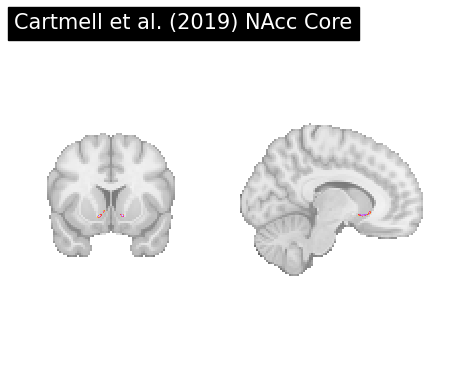

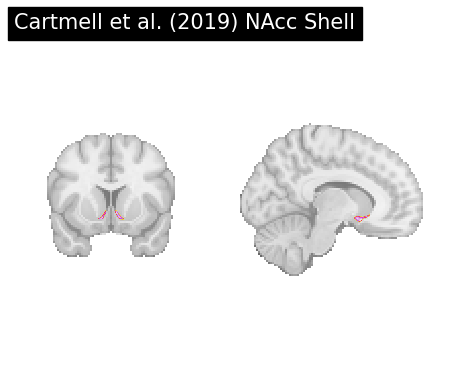

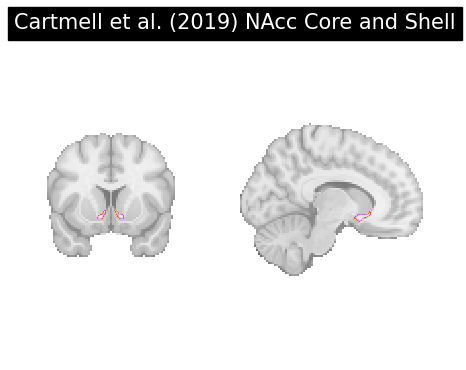

In [ ]:
# Plot the atlases.
plot_roi(NAcc_atlas_core, display_mode="yx", cut_coords=(10, 12), title="Cartmell et al. (2019) NAcc Core", annotate=False, draw_cross=False)
plot_roi(NAcc_atlas_shell, display_mode="yx", cut_coords=(10, 12), title="Cartmell et al. (2019) NAcc Shell", annotate=False, draw_cross=False)
plot_roi(NAcc_atlas, display_mode="yx", cut_coords=(10, 12), title="Cartmell et al. (2019) NAcc Core and Shell", annotate=False, draw_cross=False)


## Load fMRI files. 

### Gamble files

In [ ]:
# Load the functional files.
gamble_nii_files = glob(os.path.join(os.getcwd(), "*Gambling*.nii*"))
gamble_nii_files = sorted(gamble_nii_files)
print(gamble_nii_files)

# Load the confounds file.
gamble_confounds_files = glob(os.path.join(os.getcwd(), "*Gambling*confounds*"))
gamble_confounds_files = sorted(gamble_confounds_files)
print(gamble_confounds_files)

useful_cols = ['tx', 'ty', 'tz', 'rx', 'ry', 'rz']

gamble_confounds_files = [pd.read_csv(file, usecols=useful_cols, sep="\t") for file in gamble_confounds_files]

# Load the events file.
gamble_events_files = glob(os.path.join(os.getcwd(), "*Gambling*events*"))
gamble_events_files = sorted(gamble_events_files)
print(gamble_events_files)

# Load anatomical file.
anat_file = "/Users/luisalvarez/Documents/Datasets/IBC/sub-15/ses-0/anat/sub-15_ses-00_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz"


['/Users/luisalvarez/Documents/Datasets/IBC/sub-15/ses-02/func/sub-15_ses-02_task-HcpGambling_dir-ap_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Users/luisalvarez/Documents/Datasets/IBC/sub-15/ses-02/func/sub-15_ses-02_task-HcpGambling_dir-pa_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']
['/Users/luisalvarez/Documents/Datasets/IBC/sub-15/ses-02/func/sub-15_ses-02_task-HcpGambling_dir-ap_desc-confounds_timeseries.tsv', '/Users/luisalvarez/Documents/Datasets/IBC/sub-15/ses-02/func/sub-15_ses-02_task-HcpGambling_dir-pa_desc-confounds_timeseries.tsv']
['/Users/luisalvarez/Documents/Datasets/IBC/sub-15/ses-02/func/sub-15_ses-02_task-HcpGambling_dir-ap_events.tsv', '/Users/luisalvarez/Documents/Datasets/IBC/sub-15/ses-02/func/sub-15_ses-02_task-HcpGambling_dir-pa_events.tsv']


In [ ]:
# Create mask for each run.
mask_img = compute_multi_epi_mask(gamble_nii_files, upper_cutoff=.7, lower_cutoff=.4)

gamble_confounds_run1 = pd.DataFrame(high_variance_confounds(gamble_nii_files[0], percentile=5)) 

gamble_confounds_run1 = pd.concat([gamble_confounds_run1, gamble_confounds_files[0]], axis=1)

gamble_confounds_run2 = pd.DataFrame(high_variance_confounds(gamble_nii_files[1], mask_img=mask_img, percentile=5))

gamble_confounds_run2 = pd.concat([gamble_confounds_run2, gamble_confounds_files[1]], axis=1)

gamble_confounds_files = [gamble_confounds_run1, gamble_confounds_run2]


### Columbia Cards files.

In [ ]:
os.fchdir(ses26_path)

# Load the functional files.
cc_nii_files = glob(os.path.join(os.getcwd(), "*ColumbiaCards*.nii*"))
cc_nii_files = sorted(cc_nii_files)
print(cc_nii_files)

# Load the confounds file.
cc_confounds_files = glob(os.path.join(os.getcwd(), "*ColumbiaCards*confounds*"))
cc_confounds_files = sorted(cc_confounds_files)
print(cc_confounds_files)

cc_confounds_files = [pd.read_csv(file, usecols=useful_cols, sep="\t") for file in cc_confounds_files]

# Load the events file.
cc_events_files = glob(os.path.join(os.getcwd(), "*ColumbiaCards*events*"))
cc_events_files = sorted(cc_events_files)
print(cc_events_files)



['/Users/luisalvarez/Documents/Datasets/IBC/sub-15/ses-26/func/sub-15_ses-26_task-ColumbiaCards_dir-pa_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']
['/Users/luisalvarez/Documents/Datasets/IBC/sub-15/ses-26/func/sub-15_ses-26_task-ColumbiaCards_dir-pa_desc-confounds_timeseries.tsv']
['/Users/luisalvarez/Documents/Datasets/IBC/sub-15/ses-26/func/sub-15_ses-26_task-ColumbiaCards_dir-pa_events.tsv']


In [ ]:
# Compute high variance for CC. 
cc_confounds_pa= pd.DataFrame(high_variance_confounds(cc_nii_files[0], percentile=5)) 

cc_confounds_pa = pd.concat([cc_confounds_pa, cc_confounds_files[0]], axis=1)



In [ ]:
from ibc_public.utils_paradigm import post_process



In [ ]:
cc_events_raw_df = pd.read_csv(cc_events_files[0], sep="\t") 

cc_events_df = post_process(cc_events_raw_df, "ColumbiaCards")

print("For the Columbia Card game we have the following trial types:")
print(cc_events_df["trial_type"].value_counts())

cc_events_gain_df = cc_events_df[cc_events_df["trial_type"] == "gain"]
cc_events_loss_df = cc_events_df[cc_events_df["trial_type"] == "loss"]
cc_events_prob_df = cc_events_df[cc_events_df["trial_type"] == "num_loss_cards"]


For the Columbia Card game we have the following trial types:
gain              197
loss              197
num_loss_cards    197
Name: trial_type, dtype: int64


/Users/luisalvarez/Documents/GitHub/public_analysis_code/ibc_public/utils_paradigm.py:314: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop('loss_amount', 1, inplace=True)
/Users/luisalvarez/Documents/GitHub/public_analysis_code/ibc_public/utils_paradigm.py:315: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop('num_loss_cards', 1, inplace=True)
/Users/luisalvarez/Documents/GitHub/public_analysis_code/ibc_public/utils_paradigm.py:316: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop('gain_amount', 1, inplace=True)


In [ ]:
# Pre-proccess events files for Columbia Card game.

"""
Okay, I am making some assumptions here. Specifically, 
about the structure of the events files. I am assuming that
every event 't' card_flip is a gain, unless event 't' is card_flip
but the next event 't+1' is not card_flip; this would mean that participant 
loss and the game restarted.
"""

cc_events_raw_df = pd.read_csv(cc_events_files[0], sep="\t") 

cc_events_raw_df["Trials"] = cc_events_raw_df["trial_type"] 

lenght_df = cc_events_raw_df.shape[0]

for row_id in range(lenght_df):

    if (row_id > 0): 

        if ((cc_events_raw_df.loc[row_id, "Trials"] == "card_flip") and (cc_events_raw_df.loc[row_id+1, "Trials"] != "card_flip")):

            cc_events_raw_df.loc[row_id, "trial_type"] = "Loss"
        
        elif ((cc_events_raw_df.loc[row_id, "Trials"] == "card_flip") and (cc_events_raw_df.loc[row_id+1, "Trials"] == "card_flip")):

            cc_events_raw_df.loc[row_id, "trial_type"] = "Gain"
        
        else:
            pass

# Select only relevant events. 
cc_events_df = cc_events_raw_df[(cc_events_raw_df["trial_type"] == "Gain") | (cc_events_raw_df["trial_type"] == "Loss") | (cc_events_raw_df["trial_type"] == "inter_trials")] #| (cc_events_raw_df["trial_type"] == "rest_block") 
cc_events_df = cc_events_df[['onset', 'duration', 'trial_type']]
cc_events_df = cc_events_df.reset_index(drop=True)                    

cc_events_df.head()
 

,onset,duration,trial_type
0,2.537,6.519,Loss
1,9.056,2.472,inter_trials
2,11.528,3.007,Gain
3,14.535,2.308,Gain
4,16.843,2.168,Gain


## Create GLM model: Gambling Task .

In [ ]:
G_NAcc_atlas_bin_resampled_AP = image.resample_to_img(NAcc_atlas_bin, gamble_nii_files[0], interpolation="nearest")
G_NAcc_atlas_bin_resampled_PA = image.resample_to_img(NAcc_atlas_bin, gamble_nii_files[1], interpolation="nearest")

CC_NAcc_atlas_bin_resampled_PA = image.resample_to_img(NAcc_atlas_bin, cc_nii_files[0], interpolation="nearest")

In [ ]:
# Create GLM object for ROI-based analysis AP.
GLM_Obj_NAcc_Gamble_AP = FirstLevelModel(
    t_r=2,
    noise_model="ar1",
    standardize=False,
    hrf_model="spm + derivative", 
    high_pass= 1/128,
    slice_time_ref=0.5,
    mask_img=G_NAcc_atlas_bin_resampled_AP,
    smoothing_fwhm=5)

# Create GLM object for ROI-based analysis AP.
GLM_Obj_NAcc_Gamble_PA = FirstLevelModel(
    t_r=2,
    noise_model="ar1",
    standardize=False,
    hrf_model="spm + derivative", 
    high_pass= 1/128,
    slice_time_ref=0.5,
    mask_img=G_NAcc_atlas_bin_resampled_PA,
    smoothing_fwhm=5)

# # Create GLM object for whole-brain analysis.
# Whole_Gamble_glm_obj = FirstLevelModel(
#     t_r=2,
#     noise_model="ar1",
#     standardize=False,
#     hrf_model="spm + derivative", 
#     high_pass= 1/128,
#     slice_time_ref=0.5,
#     mask_img=mask_img,
#     smoothing_fwhm=5)

In [ ]:
# Create GLM object for ROI-based analysis AP.
GLM_Obj_NAcc_CC_PA_G = FirstLevelModel(
    t_r=2,
    noise_model="ar1",
    standardize=False,
    hrf_model="spm + derivative", 
    high_pass= 1/128,
    slice_time_ref=0.5,
    mask_img=CC_NAcc_atlas_bin_resampled_PA,
    smoothing_fwhm=5)

GLM_Obj_NAcc_CC_PA_L = FirstLevelModel(
    t_r=2,
    noise_model="ar1",
    standardize=False,
    hrf_model="spm + derivative", 
    high_pass= 1/128,
    slice_time_ref=0.5,
    mask_img=CC_NAcc_atlas_bin_resampled_PA,
    smoothing_fwhm=5)

GLM_Obj_NAcc_CC_PA_P = FirstLevelModel(
    t_r=2,
    noise_model="ar1",
    standardize=False,
    hrf_model="spm + derivative", 
    high_pass= 1/128,
    slice_time_ref=0.5,
    mask_img=CC_NAcc_atlas_bin_resampled_PA,
    smoothing_fwhm=5)

In [ ]:
# Fit GLM model. Note it requires as input the fmri file, the events dataframe, and the confounds dataframe. 
NAcc_GLM_Gamble_AP = GLM_Obj_NAcc_Gamble_AP.fit(gamble_nii_files[0], gamble_events_files[0], gamble_confounds_files[0])
NAcc_GLM_Gamble_PA = GLM_Obj_NAcc_Gamble_PA.fit(gamble_nii_files[1], gamble_events_files[1], gamble_confounds_files[1])

#whole_glm_gamble = Whole_Gamble_glm_obj.fit(gamble_nii_files[0], gamble_events_files[0], gamble_confounds_files[0])



In [ ]:
#NAcc_GLM_CC = GLM_Obj_NAcc_CC_PA.fit(cc_nii_files[0], cc_events_df, cc_confounds_pa)
NAcc_GLM_CC_Gain = GLM_Obj_NAcc_CC_PA_G.fit(cc_nii_files[0], cc_events_gain_df, cc_confounds_pa)
NAcc_GLM_CC_Loss = GLM_Obj_NAcc_CC_PA_L.fit(cc_nii_files[0], cc_events_loss_df, cc_confounds_pa)
NAcc_GLM_CC_Prob = GLM_Obj_NAcc_CC_PA_P.fit(cc_nii_files[0], cc_events_prob_df, cc_confounds_pa)


A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


In [ ]:
# Create Second-level model for ROI-based analysis.

gamble_glms_list = [NAcc_GLM_Gamble_AP, NAcc_GLM_Gamble_PA]

SecondLevelGLM_Gamble = SecondLevelModel()

NAcc_GLM_Gamble = SecondLevelGLM_Gamble.fit(gamble_glms_list)  



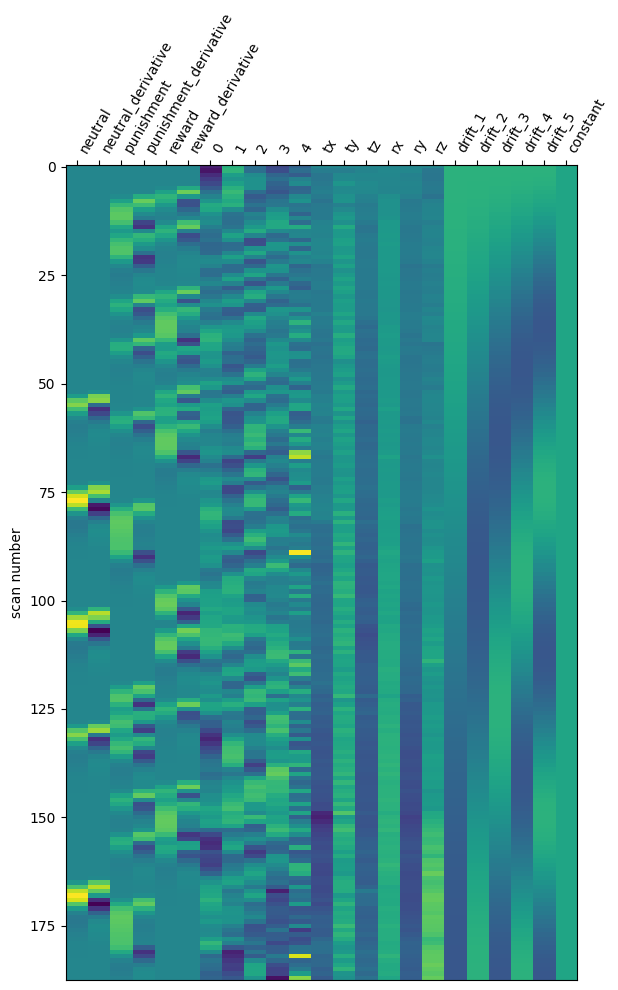

In [ ]:
plot_design_matrix(NAcc_GLM_Gamble_AP.design_matrices_[0])

plt.show()

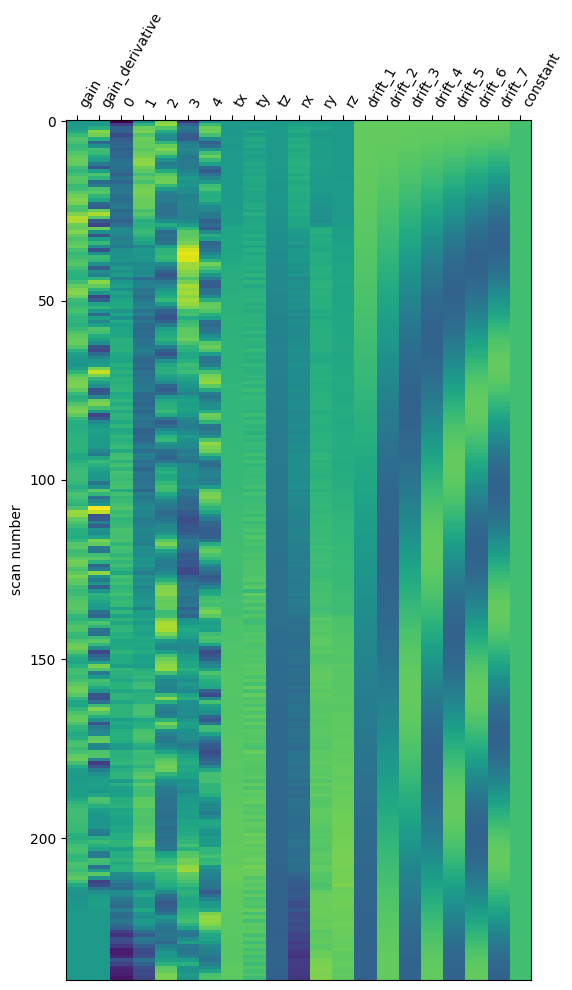

In [ ]:
plot_design_matrix(NAcc_GLM_CC_Gain.design_matrices_[0])

plt.show()

In [ ]:

# NAcc_imgs_core_bin_resampled = image.resample_to_img(NAcc_imgs_core_bin_mean, gamble_nii_files[0], interpolation="nearest")
# NAcc_imgs_shell_bin_resampled = image.resample_to_img(NAcc_imgs_shell_bin_mean, gamble_nii_files[0], interpolation="nearest")

# CC_NAcc_imgs_core_bin_resampled = image.resample_to_img(NAcc_imgs_core_bin_mean, cc_nii_files[0], interpolation="nearest")
# CC_NAcc_imgs_shell_bin_resampled = image.resample_to_img(NAcc_imgs_shell_bin_mean, cc_nii_files[0], interpolation="nearest")




/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 3.259761398361577. But, you have given threshold=inf.
  stat_img = threshold_img(
/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 3.1675704840810313. But, you have given threshold=inf.
  stat_img = threshold_img(
/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 3.6010812155738545. But, you have given threshold=inf.
  stat_img = threshold_img(


Reward - Punishment FDR p<0.05 threshold: inf
Reward - Neutral FDR p<0.05 threshold: inf
Punishment - Neutral FDR p<0.05 threshold: inf


/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:536: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  data = safe_get_data(anat_img, ensure_finite=True)
/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:74: UserWarning: The following kwargs were not used by contour: 'contours', 'linewidth'
  im = getattr(ax, type)(


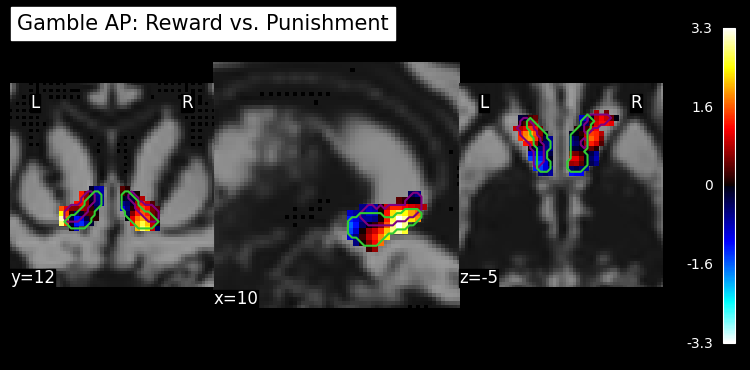

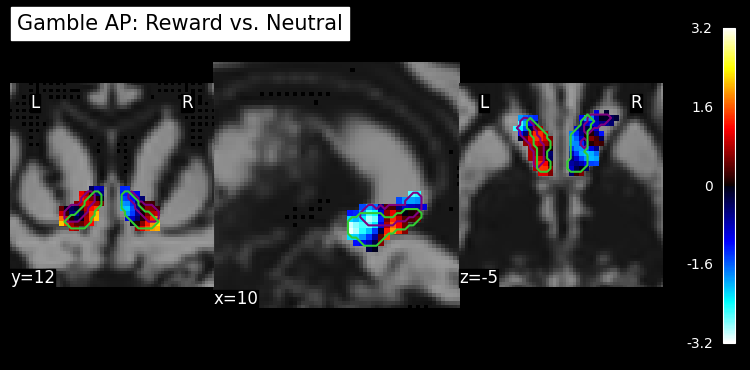

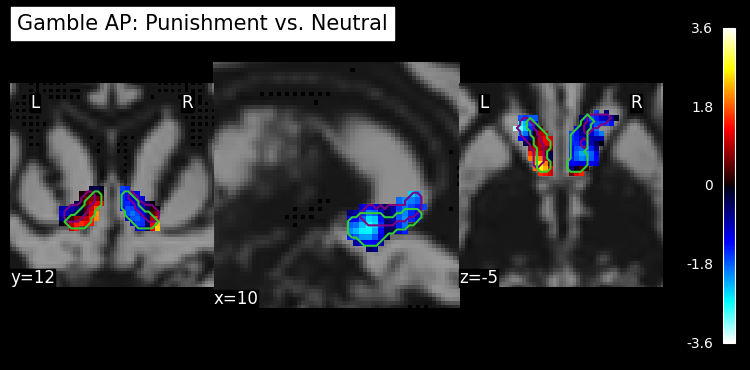

In [ ]:
# Create the orthogonal contrast to the create image. Note, the sum of all elements equals zero.
reward_minus_punishment = "+1*reward-1*punishment"
reward_minus_neutral = "+1*reward-1*neutral"
punishment_minus_neutral = "+1*punishment-1*neutral"

reward_minus_punishment_z_map = NAcc_GLM_Gamble_AP.compute_contrast(contrast_def=reward_minus_punishment, stat_type="t", output_type="z_score")
reward_minus_neutral_z_map = NAcc_GLM_Gamble_AP.compute_contrast(contrast_def=reward_minus_neutral, stat_type="t", output_type="z_score")
punishment_minus_neutral_z_map = NAcc_GLM_Gamble_AP.compute_contrast(contrast_def=punishment_minus_neutral, stat_type="t", output_type="z_score")

reward_minus_punishment_thresholded_map, reward_minus_punishment_threshold = threshold_stats_img(reward_minus_punishment_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)
reward_minus_neutral_thresholded_map, reward_minus_neutral_threshold = threshold_stats_img(reward_minus_neutral_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)
punishment_minus_neutral_thresholded_map, punishment_minus_neutral_threshold = threshold_stats_img(punishment_minus_neutral_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)

print(f"Reward - Punishment FDR p<0.05 threshold: {reward_minus_punishment_threshold:.3f}")
print(f"Reward - Neutral FDR p<0.05 threshold: {reward_minus_neutral_threshold:.3f}")
print(f"Punishment - Neutral FDR p<0.05 threshold: {punishment_minus_neutral_threshold:.3f}")

NAcc_rew_pun_fig = plot_stat_map(
    reward_minus_punishment_z_map,
    threshold=0,#2.797,
    display_mode="ortho",
    cut_coords=(10, 12, -5),
    bg_img=anat_file,
    draw_cross=False,
    title="Gamble AP: Reward vs. Punishment")

NAcc_rew_pun_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_rew_pun_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_rew_pun_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_rew_pun_fig.axes['x'].ax.set_ylim(-30, 30)
NAcc_rew_pun_fig.axes['z'].ax.set_xlim(-30, 30)
NAcc_rew_pun_fig.axes['z'].ax.set_ylim(-30, 30)

NAcc_rew_neu_fig = plot_stat_map(
    reward_minus_neutral_z_map,
    threshold=0,#2.797,
    display_mode="ortho",
    cut_coords=(10, 12, -5),
    bg_img=anat_file,
    draw_cross=False,
    title="Gamble AP: Reward vs. Neutral"
)

NAcc_rew_neu_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_rew_neu_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_rew_neu_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_rew_neu_fig.axes['x'].ax.set_ylim(-30, 30)
NAcc_rew_neu_fig.axes['z'].ax.set_xlim(-30, 30)
NAcc_rew_neu_fig.axes['z'].ax.set_ylim(-30, 30)

NAcc_pun_neu_fig = plot_stat_map( 
    punishment_minus_neutral_z_map,
    threshold=0,#2.797,
    display_mode="ortho",
    cut_coords=(10, 12, -5),
    bg_img=anat_file,
    draw_cross=False,
    title="Gamble AP: Punishment vs. Neutral"
)

NAcc_pun_neu_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_pun_neu_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_pun_neu_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_pun_neu_fig.axes['x'].ax.set_ylim(-30, 30)
NAcc_pun_neu_fig.axes['z'].ax.set_xlim(-30, 30)
NAcc_pun_neu_fig.axes['z'].ax.set_ylim(-30, 30)

masks = [NAcc_core_contour, NAcc_shell_contour]
colors = ["purple", "limegreen"]

for mask, color in zip(masks, colors):
    NAcc_rew_pun_fig.add_contours(
        mask,
        contours=0.1,
        antialiased=True,
        linewidth=1,
        levels=[0],
        colors=[color])
    NAcc_rew_neu_fig.add_contours(
        mask,
        contours=0.1,
        antialiased=True,
        linewidth=1,
        levels=[0],
        colors=[color])
    NAcc_pun_neu_fig.add_contours(
        mask,
        contours=0.1,
        antialiased=True,
        linewidth=1,
        levels=[0],
        colors=[color])



/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 3.359544346638934. But, you have given threshold=inf.
  stat_img = threshold_img(
/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 3.230782662543922. But, you have given threshold=inf.
  stat_img = threshold_img(


Reward - Punishment FDR p<0.05 threshold: inf
Reward - Neutral FDR p<0.05 threshold: 3.767
Punishment - Neutral FDR p<0.05 threshold: inf


/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:536: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  data = safe_get_data(anat_img, ensure_finite=True)
/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:74: UserWarning: The following kwargs were not used by contour: 'contours', 'linewidth'
  im = getattr(ax, type)(


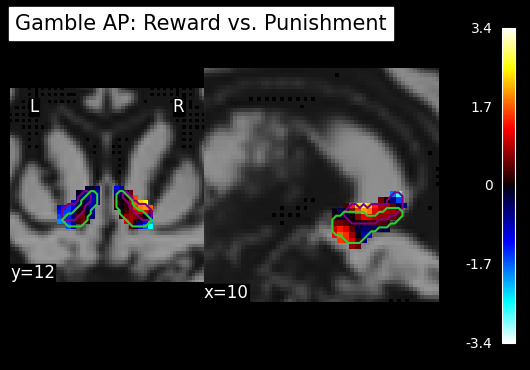

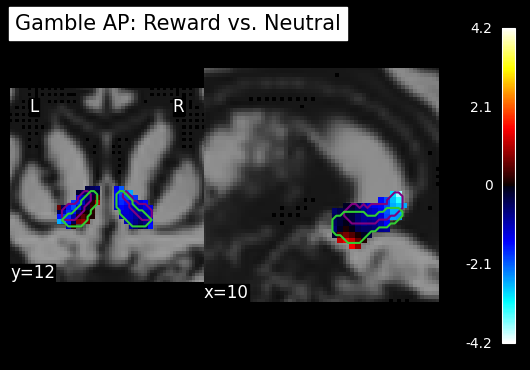

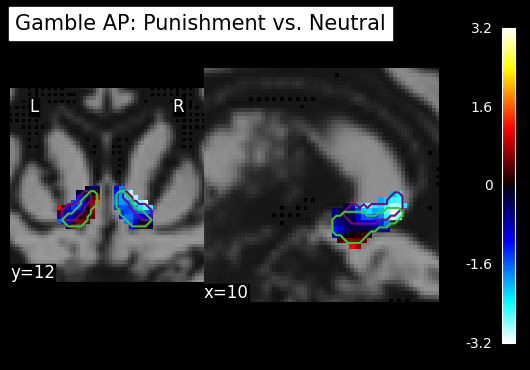

In [ ]:
reward_minus_punishment_z_map = NAcc_GLM_Gamble_PA.compute_contrast(contrast_def=reward_minus_punishment, stat_type="t", output_type="z_score")
reward_minus_neutral_z_map = NAcc_GLM_Gamble_PA.compute_contrast(contrast_def=reward_minus_neutral, stat_type="t", output_type="z_score")
punishment_minus_neutral_z_map = NAcc_GLM_Gamble_PA.compute_contrast(contrast_def=punishment_minus_neutral, stat_type="t", output_type="z_score")

reward_minus_punishment_thresholded_map, reward_minus_punishment_threshold = threshold_stats_img(reward_minus_punishment_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)
reward_minus_neutral_thresholded_map, reward_minus_neutral_threshold = threshold_stats_img(reward_minus_neutral_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)
punishment_minus_neutral_thresholded_map, punishment_minus_neutral_threshold = threshold_stats_img(punishment_minus_neutral_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)

print(f"Reward - Punishment FDR p<0.05 threshold: {reward_minus_punishment_threshold:.3f}")
print(f"Reward - Neutral FDR p<0.05 threshold: {reward_minus_neutral_threshold:.3f}")
print(f"Punishment - Neutral FDR p<0.05 threshold: {punishment_minus_neutral_threshold:.3f}")

NAcc_rew_pun_fig = plot_stat_map(
    reward_minus_punishment_z_map,
    threshold=0,#2.797,
    display_mode="ortho",
    cut_coords=(10, 12, -5),
    bg_img=anat_file,
    draw_cross=False,
    title="Gamble AP: Reward vs. Punishment"
)

NAcc_rew_pun_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_rew_pun_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_rew_pun_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_rew_pun_fig.axes['x'].ax.set_ylim(-30, 30)

NAcc_rew_neu_fig = plot_stat_map(
    reward_minus_neutral_z_map,
    threshold=0,#2.797,
    display_mode="ortho",
    cut_coords=(10, 12, -5),
    bg_img=anat_file,
    draw_cross=False,
    title="Gamble AP: Reward vs. Neutral"
)

NAcc_rew_neu_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_rew_neu_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_rew_neu_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_rew_neu_fig.axes['x'].ax.set_ylim(-30, 30)

NAcc_pun_neu_fig = plot_stat_map( 
    punishment_minus_neutral_z_map,
    threshold=0,#2.797,
    display_mode="ortho",
    cut_coords=(10, 12, -5),
    bg_img=anat_file,
    draw_cross=False,
    title="Gamble AP: Punishment vs. Neutral"
)

NAcc_pun_neu_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_pun_neu_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_pun_neu_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_pun_neu_fig.axes['x'].ax.set_ylim(-30, 30)

masks = [NAcc_core_contour, NAcc_shell_contour]
colors = ["purple", "limegreen"]

for mask, color in zip(masks, colors):
    NAcc_rew_pun_fig.add_contours(
        mask,
        contours=0.1,
        antialiased=True,
        linewidth=1,
        levels=[0],
        colors=[color])
    NAcc_rew_neu_fig.add_contours(
        mask,
        contours=0.1,
        antialiased=True,
        linewidth=1,
        levels=[0],
        colors=[color])
    NAcc_pun_neu_fig.add_contours(
        mask,
        contours=0.1,
        antialiased=True,
        linewidth=1,
        levels=[0],
        colors=[color])

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 3.558730397962352. But, you have given threshold=inf.
  stat_img = threshold_img(
/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 3.549027482456126. But, you have given threshold=inf.
  stat_img = threshold_img(


Reward - Punishment FDR p<0.05 threshold: inf
Reward - Neutral FDR p<0.05 threshold: inf
Punishment - Neutral FDR p<0.05 threshold: 4.381


/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:536: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  data = safe_get_data(anat_img, ensure_finite=True)
/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:74: UserWarning: The following kwargs were not used by contour: 'contours', 'linewidth'
  im = getattr(ax, type)(


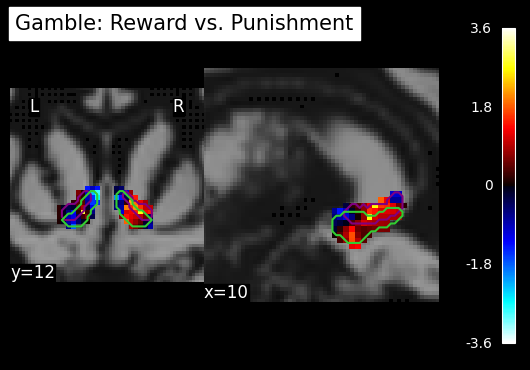

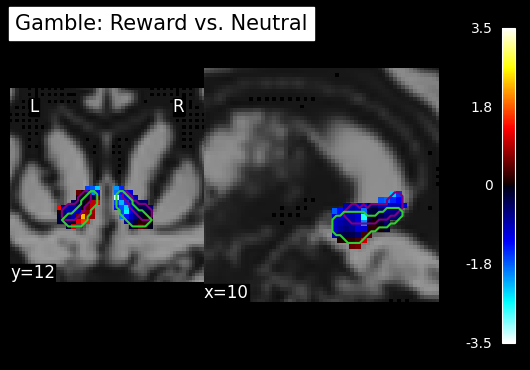

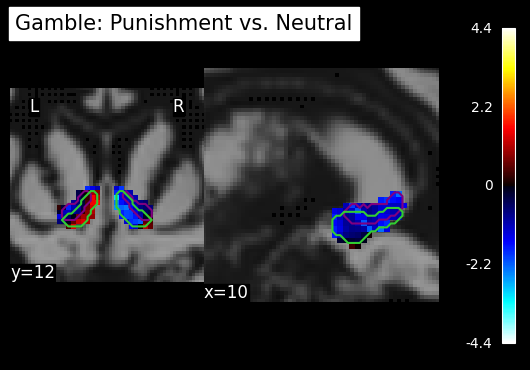

In [ ]:
reward_minus_punishment_z_map = NAcc_GLM_Gamble.compute_contrast(first_level_contrast=reward_minus_punishment, output_type="z_score")
reward_minus_neutral_z_map = NAcc_GLM_Gamble.compute_contrast(first_level_contrast=reward_minus_neutral, output_type="z_score")
punishment_minus_neutral_z_map = NAcc_GLM_Gamble.compute_contrast(first_level_contrast=punishment_minus_neutral, output_type="z_score")

reward_minus_punishment_thresholded_map, reward_minus_punishment_threshold = threshold_stats_img(reward_minus_punishment_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)
reward_minus_neutral_thresholded_map, reward_minus_neutral_threshold = threshold_stats_img(reward_minus_neutral_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)
punishment_minus_neutral_thresholded_map, punishment_minus_neutral_threshold = threshold_stats_img(punishment_minus_neutral_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)

print(f"Reward - Punishment FDR p<0.05 threshold: {reward_minus_punishment_threshold:.3f}")
print(f"Reward - Neutral FDR p<0.05 threshold: {reward_minus_neutral_threshold:.3f}")
print(f"Punishment - Neutral FDR p<0.05 threshold: {punishment_minus_neutral_threshold:.3f}")

NAcc_rew_pun_fig = plot_stat_map(
    reward_minus_punishment_z_map,
    threshold=0,#2.797,
    display_mode="yx",
    cut_coords=(10, 12),
    bg_img=anat_file,
    draw_cross=False,
    title="Gamble: Reward vs. Punishment"
)

NAcc_rew_pun_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_rew_pun_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_rew_pun_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_rew_pun_fig.axes['x'].ax.set_ylim(-30, 30)

NAcc_rew_neu_fig = plot_stat_map(
    reward_minus_neutral_z_map,
    threshold=0,#2.797,
    display_mode="yx",
    cut_coords=(10, 12),
    bg_img=anat_file,
    draw_cross=False,
    title="Gamble: Reward vs. Neutral"
)

NAcc_rew_neu_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_rew_neu_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_rew_neu_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_rew_neu_fig.axes['x'].ax.set_ylim(-30, 30)

NAcc_pun_neu_fig = plot_stat_map( 
    punishment_minus_neutral_z_map,
    threshold=0,#2.797,
    display_mode="yx",
    cut_coords=(10, 12),
    bg_img=anat_file,
    draw_cross=False,
    title="Gamble: Punishment vs. Neutral"
)

NAcc_pun_neu_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_pun_neu_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_pun_neu_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_pun_neu_fig.axes['x'].ax.set_ylim(-30, 30)

masks = [NAcc_core_contour, NAcc_shell_contour]
colors = ["purple", "limegreen"]

for mask, color in zip(masks, colors):
    NAcc_rew_pun_fig.add_contours(
        mask,
        contours=0.1,
        antialiased=True,
        linewidth=1,
        levels=[0],
        colors=[color])
    NAcc_rew_neu_fig.add_contours(
        mask,
        contours=0.1,
        antialiased=True,
        linewidth=1,
        levels=[0],
        colors=[color])
    NAcc_pun_neu_fig.add_contours(
        mask,
        contours=0.1,
        antialiased=True,
        linewidth=1,
        levels=[0],
        colors=[color])

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 3.022072193404425. But, you have given threshold=inf.
  stat_img = threshold_img(


CC: Gain FDR p<0.05 threshold: inf
CC: Loss FDR p<0.05 threshold: 3.118
CC: Prob FDR p<0.05 threshold: 4.468


/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:536: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  data = safe_get_data(anat_img, ensure_finite=True)
/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/displays/_axes.py:74: UserWarning: The following kwargs were not used by contour: 'contours', 'linewidth'
  im = getattr(ax, type)(


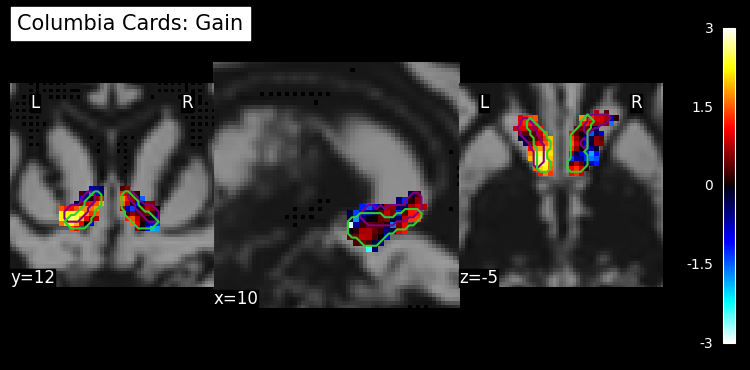

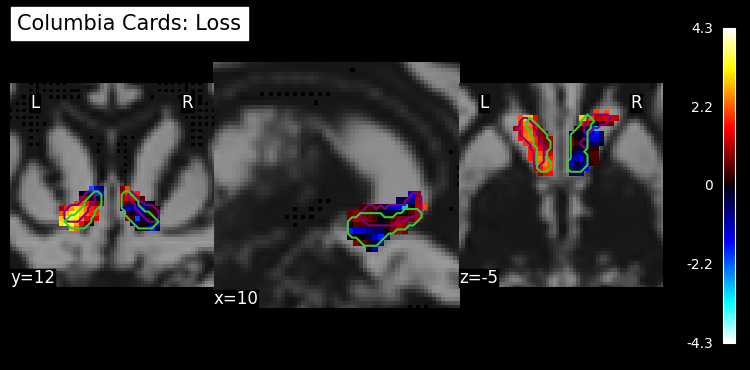

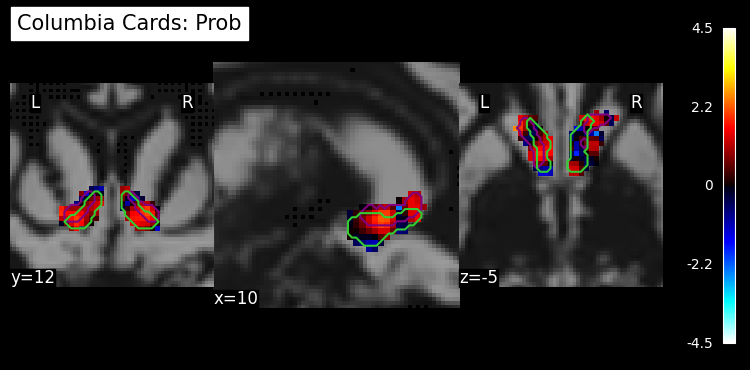

In [ ]:
gain_cc = "+1*gain"
loss_cc = "+1*loss"
prob_cc = "+1*num_loss_cards"

gain_cc_z_map = NAcc_GLM_CC_Gain.compute_contrast(contrast_def=gain_cc, stat_type="F", output_type="z_score")
loss_cc_z_map = NAcc_GLM_CC_Loss.compute_contrast(contrast_def=loss_cc, stat_type="F", output_type="z_score")
prob_cc_z_map = NAcc_GLM_CC_Prob.compute_contrast(contrast_def=prob_cc, stat_type="F", output_type="z_score")

gain_cc_thresholded_map, gain_cc_threshold = threshold_stats_img(gain_cc_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)
loss_cc_thresholded_map, loss_cc_threshold = threshold_stats_img(loss_cc_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)
prob_cc_thresholded_map, prob_cc_threshold = threshold_stats_img(prob_cc_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)

print(f"CC: Gain FDR p<0.05 threshold: {gain_cc_threshold:.3f}")
print(f"CC: Loss FDR p<0.05 threshold: {loss_cc_threshold:.3f}")
print(f"CC: Prob FDR p<0.05 threshold: {prob_cc_threshold:.3f}")

NAcc_cc_gain_fig = plot_stat_map(
    gain_cc_z_map,
    threshold=0,#2.797,
    display_mode="ortho",
    cut_coords=(10, 12, -5),
    bg_img=anat_file,
    draw_cross=False,
    title="Columbia Cards: Gain"
)

NAcc_cc_gain_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_cc_gain_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_cc_gain_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_cc_gain_fig.axes['x'].ax.set_ylim(-30, 30)
NAcc_cc_gain_fig.axes['z'].ax.set_xlim(-30, 30)
NAcc_cc_gain_fig.axes['z'].ax.set_ylim(-30, 30)

NAcc_cc_loss_fig = plot_stat_map(
    loss_cc_z_map,
    threshold=0,#2.797,
    display_mode="ortho",
    cut_coords=(10, 12, -5),
    bg_img=anat_file,
    draw_cross=False,
    title="Columbia Cards: Loss"
)

NAcc_cc_loss_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_cc_loss_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_cc_loss_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_cc_loss_fig.axes['x'].ax.set_ylim(-30, 30)
NAcc_cc_loss_fig.axes['z'].ax.set_xlim(-30, 30)
NAcc_cc_loss_fig.axes['z'].ax.set_ylim(-30, 30)

NAcc_cc_prob_fig = plot_stat_map(
    prob_cc_z_map,
    threshold=0,#2.797,
    display_mode="ortho",
    cut_coords=(10, 12, -5),
    bg_img=anat_file,
    draw_cross=False,
    title="Columbia Cards: Prob"
)

NAcc_cc_prob_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_cc_prob_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_cc_prob_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_cc_prob_fig.axes['x'].ax.set_ylim(-30, 30)
NAcc_cc_prob_fig.axes['z'].ax.set_xlim(-30, 30)
NAcc_cc_prob_fig.axes['z'].ax.set_ylim(-30, 30)

masks = [NAcc_core_contour, NAcc_shell_contour]
colors = ["purple", "limegreen"]

for mask, color in zip(masks, colors):
    NAcc_cc_gain_fig.add_contours(
        mask,
        contours=0.1,
        antialiased=True,
        linewidth=1,
        levels=[0],
        colors=[color])
    
    NAcc_cc_loss_fig.add_contours(
        mask,
        contours=0.1,
        antialiased=True,
        linewidth=1,
        levels=[0],
        colors=[color])
    
    NAcc_cc_prob_fig.add_contours(
        mask,
        contours=0.1,
        antialiased=True,
        linewidth=1,
        levels=[0],
        colors=[color])



In [ ]:
cc_gain = "+1*gain"

cc_gain_map = NAcc_GLM_CC.compute_contrast(contrast_def=cc_gain, stat_type="t", output_type="z_score")

cc_gain_map_thresholded_map, cc_gain_map_threshold = threshold_stats_img(cc_gain_map, alpha=0.05, height_control="fdr", cluster_threshold=0)

print(f"Gain - Loss FDR p<0.05 threshold: {cc_gain_map_threshold:.3f}")

NAcc_CC_gain_fig = plot_stat_map(
    cc_gain_map,
    threshold=0,#2.797,
    display_mode="yx",
    cut_coords=(10, 12),
    bg_img=anat_file,
    draw_cross=False,
    title="Columbia Cards: Gain"
)

NAcc_CC_gain_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_CC_gain_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_CC_gain_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_CC_gain_fig.axes['x'].ax.set_ylim(-30, 30)

masks = [NAcc_core_contour, NAcc_shell_contour]
colors = ["purple", "limegreen"]

for mask, color in zip(masks, colors):
    NAcc_CC_gain_fig.add_contours(
        mask,
        contours=0.1,
        antialiased=True,
        linewidth=1,
        levels=[0],
        colors=[color])

ValueError: The expression (+1*gain) is not valid. This could be due to defining the contrasts using design matrix columns that are invalid python identifiers.

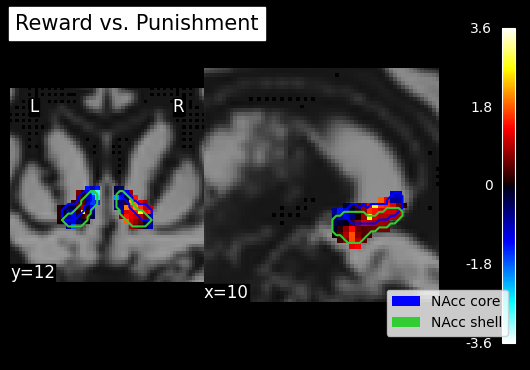

In [ ]:
# Check how to add contours to the plots. 

masks = [NAcc_core_contour, NAcc_shell_contour]
colors = ["blue", "red"]
NAcc_rew_pun_fig = plot_stat_map(
    reward_minus_punishment_z_map,
    threshold=0,#2.797,
    display_mode="yx",
    cut_coords=(10, 12),
    bg_img=anat_file,
    draw_cross=False,
    title="Reward vs. Punishment"
)

NAcc_rew_pun_fig.axes['y'].ax.set_xlim(-30, 30)
NAcc_rew_pun_fig.axes['y'].ax.set_ylim(-30, 30)
NAcc_rew_pun_fig.axes['x'].ax.set_xlim(-30, 30)
NAcc_rew_pun_fig.axes['x'].ax.set_ylim(-30, 30)

masks = [NAcc_core_contour, NAcc_shell_contour]
colors = ["blue", "limegreen"]
for mask, color in zip(masks, colors):
    NAcc_rew_pun_fig.add_contours(
        mask,
        contours=0.1,
        antialiased=True,
        linewidth=1,
        levels=[0],
        colors=[color],
    )

from matplotlib.patches import Rectangle

core_r = Rectangle((0, 0), 1, 1, fc="blue")
shell_r = Rectangle((0, 0), 1, 1, fc="limegreen")
plt.legend([core_r, shell_r], ["NAcc core", "NAcc shell"], loc="lower right")

